# MCMC

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/
# and pymc3 and arviz

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3
    !pip install arviz

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

TODO: introduction to MCMC

## Simulating Hockey

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, $\lambda$, in goals per game.

For the first example, I'll assume that $\lambda$ is somehow known to be 2.4.  Since regulation play (as opposed to overtime) is 60 minutes, we can compute the goal scoring rate per minute.

In [4]:
from utils import decorate

def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    decorate(xlabel='Number of goals',
        ylabel=ylabel,
        title='Distribution of goals scored')

## Poisson process



We can use NumPy to generate a sample from a Poisson distribution.

In [5]:
from empiricaldist import Pmf

def plot_pmf(sample, **options):
    """Compute and plot the PMF of a sample."""
    Pmf.from_seq(sample).bar(**options)

In [6]:
from empiricaldist import Cdf

def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    Cdf.from_seq(sample).plot(**options)

In [12]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    decorate(xlabel='Goals per game (mu)',
        ylabel=ylabel,
        title='Distribution of goal scoring rate')

## Grid approximation

Review the prior


To construct a better prior, I'll use a Gamma distribution with parameters chosen to be consistent with previous playoff games.

We can use `make_gamma_dist` to construct a prior suite with the given parameters.

In [52]:
from utils import make_gamma_dist

alpha = 1.4
beta = 1.0

dist = make_gamma_dist(alpha, beta)

In [53]:
import numpy as np
from utils import make_pmf

mus = np.linspace(0, 10, 101)
gamma_prior = make_pmf(dist, mus)
gamma_prior.mean(), gamma_prior.std()

(1.4140818156118378, 1.1756016104649656)

Here's what it looks like.

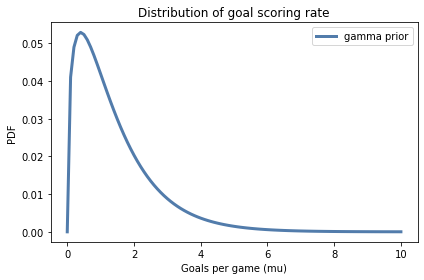

In [54]:
gamma_prior.plot(label='gamma prior')
decorate_rate()

In [68]:
from utils import make_poisson

goals = np.arange(10)
pmf_seq = [make_poisson_pmf(lam, goals) for lam in prior.qs]



ImportError: cannot import name 'make_poisson' from 'utils' (/home/downey/ThinkBayes2/soln/utils.py)

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here are the parameters we used to create the gamma prior:

In [60]:
print(alpha, beta)

1.4 1.0


Here's what the PyMC model looks like:

In [61]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [62]:
sample_prior_pymc = trace['mu']
np.mean(sample_prior_pymc)

1.4445235043808922

And compare it to a sample from the gamma prior.

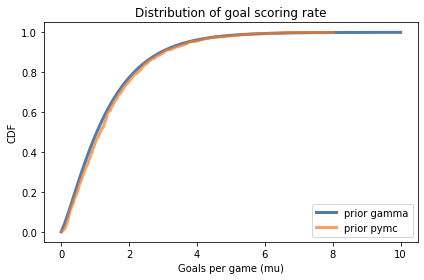

In [67]:
gamma_prior.make_cdf().plot(label='prior gamma')
plot_cdf(sample_prior_pymc, label='prior pymc')
decorate_rate('CDF')

It looks pretty good.

## Prior predictive

The distributions of `goals` from this model is the prior predictive.

In [35]:
sample_prior_pred_pymc = trace['goals']
np.mean(sample_prior_pred_pymc)

2.507

And let's compare it to a prior predictive distribution estimated by sampling.

In [36]:
sample_prior_pred = np.random.poisson(sample_prior_gamma)
np.mean(sample_prior_pred)

2.402

In [39]:
def plot_pred(sample, **options):
    cdf = Cdf.from_seq(sample)
    cdf.step(**options)

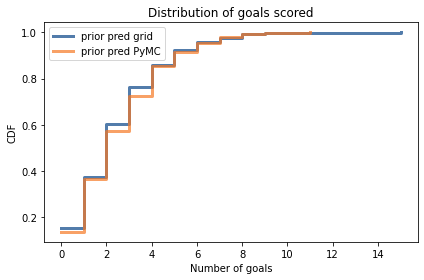

In [40]:
plot_pred(sample_prior_pred, label='prior pred grid')
plot_pred(sample_prior_pred_pymc, label='prior pred PyMC')
decorate_goals('CDF')

Looks good.

## Grid Update

In [55]:
from scipy.stats import poisson

data = 4
likelihood = poisson.pmf(data, mus)

In [58]:
posterior = gamma_prior * likelihood
posterior.normalize()

0.05015532557804499

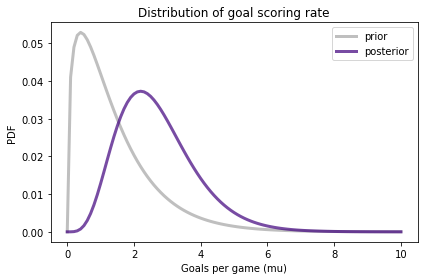

In [59]:
gamma_prior.plot(label='prior', color='C5')
posterior.plot(label='posterior', color='C4')
decorate_rate()

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of called `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [41]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2420.28draws/s]


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

In [42]:
len(trace['mu'])

1000

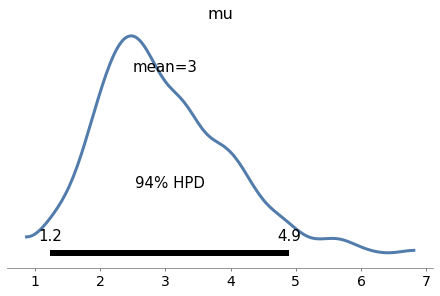

In [43]:
with model:
    pm.plot_posterior(trace)

We can extract a sample of `mu` from the trace.

In [44]:
sample_post_pymc = trace['mu']
np.mean(sample_post_pymc)

3.0007489750142775

And compare it to the sample we drew from the grid approximation:

In [45]:
sample_post_grid = posterior2.sample(1000, replace=True)
sample_post_grid.mean()

2.9573

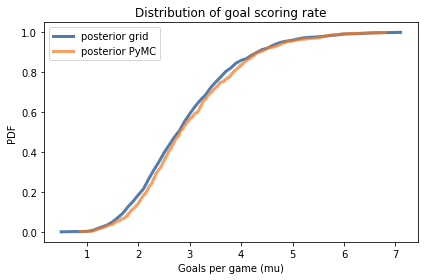

In [46]:
plot_cdf(sample_post_grid, label='posterior grid')
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_rate()

Again, it looks pretty good.

## Posterior predictive

To sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

In [47]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2557.64it/s]


Here's what it looks like:

In [48]:
sample_post_pred_pymc = post_pred['goals']
np.mean(sample_post_pred_pymc)

2.961

In [49]:
sample_post_pred = poisson(sample_post_grid).rvs()
sample_post_pred.mean()

3.086

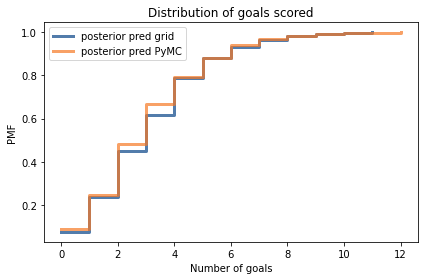

In [51]:
plot_pred(sample_post_pred, label='posterior pred grid')
plot_pred(sample_post_pred_pymc, label='posterior pred PyMC')
decorate_goals()

Looks pretty good!